## Dataset preparation

In [1]:
#pip install -e .
#pip install  abbyy_course_cvdl_t2

from pathlib import Path
from course_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

import torch

from task1pack.utils.data import HeatmapDataset

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_PATH = Path() / '..' / '..' / 'data' / 'midv500_compressed'
#DATASET_PATH = Path() / '..' / '..' / '..' / '..' / '..' / '..' / 'Downloads' / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [3]:
# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_ocr_t1.data.MidvPackage)

In [4]:
from torchvision.transforms import Resize, Compose, ToTensor

IMAGE_SIZE = [512, 512]
HEATMAP_SIZE = [128, 128]

transforms = Compose([
    ToTensor(),
    Resize(IMAGE_SIZE),
])

In [5]:
train_dataset = HeatmapDataset(data_packs=data_packs, split='train', transforms=transforms, output_size=HEATMAP_SIZE)
test_dataset = HeatmapDataset(data_packs=data_packs, split='test', transforms=transforms, output_size=HEATMAP_SIZE)

len(train_dataset), len(test_dataset)

(10750, 4250)

In [6]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([3, 512, 512]), torch.Size([4, 2]))

In [7]:
torch.manual_seed(42)

In [8]:
device = 'cuda:2'

## Model

In [9]:
from task1pack.models.hrnet import get_pose_net
from task1pack.models.hrnet_config import cfg

In [10]:
cfg['MODEL']['IMAGE_SIZE'] = IMAGE_SIZE
cfg['MODEL']['HEATMAP_SIZE'] = HEATMAP_SIZE

In [11]:
hrnet = get_pose_net(is_train=True, cfg=cfg)

### Train

In [12]:
from task1pack.utils.train import train_model, show_train_plots, train_old
from torch.nn import MSELoss
import wandb

In [13]:
model_name = 'HRNet'

train_dataloader_config = {
    'batch_size': 8,
    'shuffle': True,
}

test_dataloader_config = {
    'batch_size': 8,
    'shuffle': False,
}

training_config = {
    'lr': 1e-3,
    'epochs': 100,
    'step_size': 15,
    'gamma': 0.1,
}

device = 'cuda:2'
criterion = MSELoss()

wandb.init(
    project='ocr task 1',
    name='{} {} epochs with lr={}'.format(model_name, training_config['epochs'], training_config['lr']),
    config={
        'train_dataloader_config': train_dataloader_config,
        'test_dataloader_config': test_dataloader_config,
        'training_config': training_config,

    "architecture": model_name,
    "dataset": "MIDV-500",
    "criterion": "MSELoss",
    "optimizer": "Adam",
    "image_size": IMAGE_SIZE,
    "heatmap_size": HEATMAP_SIZE,    
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vashchilkoav. Use `wandb login --relogin` to force relogin


In [14]:
train_losses, test_losses, trained_model = train_model(
    train_dataset=train_dataset, 
    test_dataset=test_dataset, 
    model=hrnet, 
    train_dataloader_kwargs=train_dataloader_config, 
    test_dataloader_kwargs=test_dataloader_config, 
    training_kwargs=training_config,
    criterion=criterion,
    device=device,
    wandb_instance=wandb,
)

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


initial loss 0.11798489093780518
epoch 0 started
train loss: 0.11378882543344628, test_loss: 0.062713623046875
epoch 1 started
train loss: 0.0510371891134474, test_loss: 0.052372951060533524
epoch 2 started
train loss: 0.04165005045381674, test_loss: 0.020432356745004654
epoch 3 started
train loss: 0.03158309994268209, test_loss: 0.016394417732954025
epoch 4 started
train loss: 0.027990504541992863, test_loss: 0.019451584666967392
epoch 5 started
train loss: 0.034902603600563624, test_loss: 0.01999414525926113
epoch 6 started
train loss: 0.029374893404262064, test_loss: 0.015446779318153858
epoch 7 started
train loss: 0.02697539211970122, test_loss: 0.014563276432454586
epoch 8 started
train loss: 0.03471335854694536, test_loss: 0.025932764634490013
epoch 9 started
train loss: 0.03254344650468695, test_loss: 0.015359996818006039
epoch 10 started
train loss: 0.03360020659203569, test_loss: 0.015497403219342232
epoch 11 started
train loss: 0.02666540662886248, test_loss: 0.01451937109231

train loss: 0.025108236406335242, test_loss: 0.01352549996227026


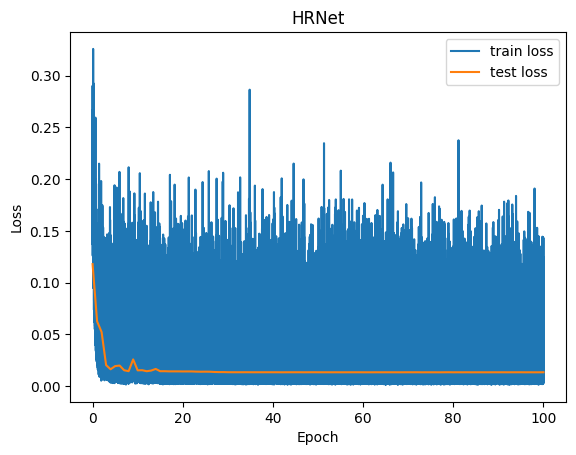

In [15]:
show_train_plots(train_losses, test_losses, 'HRNet')

### Сохраним результаты и измерим точность
Результаты - словарь с ключем DataItem.unique_key() и значением предсказанным quadrangle в относительных единицах.

In [16]:
from course_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy

results_dict = {}

trained_model.eval()

with torch.no_grad():
    for i, (x, _) in tqdm(enumerate(test_dataset)):
        result = trained_model(x[None, ...].to(device))[0]
        key = test_dataset.get_key(i)
        results_dict[key] = result.cpu().tolist()

dump_results_dict(results_dict, Path() / 'pred1.json')

acc_95 = measure_crop_accuracy(
    Path() / 'pred1.json',
    Path() / 'gt.json'
)

acc_80 = measure_crop_accuracy(
    Path() / 'pred1.json',
    Path() / 'gt.json',
    iou_thr=0.8
)

wandb.run.summary['acc@95'] = acc_95
wandb.run.summary['acc@80'] = acc_80

torch.save(trained_model.state_dict(), Path() / 'model1.pth')
wandb.save(str(Path() / 'model1.pth'))
wandb.save(str(Path() / 'pred1.json'))

wandb.finish()

print(acc_95)

4250it [02:33, 27.76it/s]
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in inte

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.inte

lr,██████▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc@80,0.16235
acc@95,0.00094
lr,0.0


0.0009411764705882353
